In [1032]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys


if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
from lib.envs.cliff_walking import CliffWalkingEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [1033]:
import numpy as np
import sys

from gym.envs.toy_text import discrete


SET1 = 0 # [16, 16]
SET2 = 1 # [16, 8]
SET3 = 2 # [16, 4]
SET4 = 3 # [8, 8]
SET5 = 4 # [8, 4]
SET6 = 5 # [4, 4]

TotalResource = 140
LayerResource = [18, 16, 14, 12, 10, 8]


def categorical_sample(prob_n, np_random):
    """
    Sample from categorical distribution
    Each row specifies class probabilities
    """
    """
    In this case, there is only one prob_n
    The transition probability is not used in Q-Learning
    Q-Learning is model-free
    """
    
    prob_n = np.asarray(prob_n)
    csprob_n = np.cumsum(prob_n)
    return (csprob_n > np_random.rand()).argmax()


class DNNEnv(discrete.DiscreteEnv):

    metadata = {'render.modes': ['human', 'ansi']}

    actionSets = []
    
      
    
    def get_final_status(self):
        final_area = np.sum( self.actionSets, axis = 0 )[1]
        return final_area
    
    
    def compute_reward(self, state, action):
        curr_area = np.sum( self.actionSets, axis = 0 )[1]
        
        if( state == self.nS - 1 ):
            if( curr_area <= TotalResource ):
                reward = 100.0
                done = True
            else:
                reward = -10.0
                done = True
        elif( curr_area > TotalResource ):
            reward = -10.0
            done = True
        else:
            reward = 0.0
            done = False
        
        #print("area: %d, s: %d, reward: %d\n" % (curr_area, state, reward) )
        done = False
        return reward, done
        
    
    def step(self, action):
        #transitions = self.P[self.s][action]
        
        #i = categorical_sample([t[0] for t in transitions], self.np_random)
        ## i is always zero in this case
        
        #prob, next_state, reward, done = transitions[i]
        #prob does not make any difference
        
        self.actionSets.append([action, LayerResource[action]])
        prob, next_state, reward, done = self.P[self.s][action][0]
        reward, _ = self.compute_reward(self.s, action)
        
        self.s = next_state
        self.lastaction = action
        
        return (next_state, reward, done, {"prob" : prob})
    
    
        
    
    def _calculate_transition_prob(self, state, move):
        prob = 1.0 / self.nA
        new_state = state + 1 if (state+1 < self.nS) else self.nS - 1
        #reward = self.compute_reward(state, move)
        reward = 0.0
        is_done = True if (state == self.nS - 1) else False
        return [(prob, new_state, reward, is_done)]

    
    
    def __init__(self):
        
        #P: transitions (*)
        #isd: initial state distribution (**)
        #(*) dictionary dict of dicts of lists, where
        #P[s][a] == [(probability, nextstate, reward, done), ...]
        #(**) list or array of length nS
    
    
        self.shape = (10)

        self.nS = np.prod(self.shape)
        self.nA = 6
        self.actionSets = []

        # We always start in state (0, 0) --> layer1, SET1                              
        isd = np.zeros(self.nS)
        isd[0] = 1.0
        self.actionSets.append([0, LayerResource[0]])
        
        # Calculate transition probabilities
        P = {}
        for s in range(self.nS):
            
            P[s] = { a : [] for a in range(self.nA) }
            
            P[s][SET1] = self._calculate_transition_prob(s, 0)
            P[s][SET2] = self._calculate_transition_prob(s, 1)
            P[s][SET3] = self._calculate_transition_prob(s, 2)
            P[s][SET4] = self._calculate_transition_prob(s, 3)
            P[s][SET5] = self._calculate_transition_prob(s, 4)
            P[s][SET6] = self._calculate_transition_prob(s, 5)

            #print("S: ", s)
            #print(P[s])
        

        super(DNNEnv, self).__init__(self.nS, self.nA, P, isd)
        
        
        
    def reset(self):
        self.actionSets = []
        self.s = categorical_sample(self.isd, self.np_random)
        self.lastaction=None
        return self.s
    
    
    

    def render(self, mode='human', close=False):
        self._render(mode, close)

    def _render(self, mode='human', close=False):
        if close:
            return

        outfile = StringIO() if mode == 'ansi' else sys.stdout

        for s in range(self.nS):
            position = np.unravel_index(s, self.shape)
            print(self.s)
            print(position)
            
            if position[1] == 0:
                output = output.lstrip() 
            if position[1] == self.shape[1] - 1:
                output = output.rstrip() 
                output += "\n"

            outfile.write(output)
        outfile.write("\n")


In [1034]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        
        
        #print("Q[observation]")
        #print(Q[observation])
        
        
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [1035]:
def print_Q(Q, nA, nS):
    for s in range(0, nS):
        print("S", s, end=" ")
        print(Q[s], end=" ")
        print("")
    print("")

In [1036]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=1.0, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    nA = env.action_space.n
    nS = env.observation_space.n
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(nA))
    #Q = defaultdict(lambda: np.random.random(nA))
    
    #print_Q(Q, nA, nS)
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        #print("=====Episode: ", i_episode)
        
        # Reset the environment and pick the first action
        state = env.reset()
        #print("First State: ", state)
        
        # One step in the environment
        # total_reward = 0.0
        
        #print_Q(Q, nA, nS)
        
        
        for t in itertools.count():
            #print("Iteration: ", t)
            
            # Take a step
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            
            
            
            #print("-> action_prob: ", action_probs)
            #print("itr %d -> action: %d" % (t, action))
            #print("")
            
            
            next_state, reward, done, _ = env.step(action)
            
            #print("Next State: ", next_state, end="   ")
            #print("Done: ", done, end = "   ")
            #print("reward: ", reward)
            

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            
            # TD Update
            best_next_action = np.argmax(Q[next_state])    
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
                
            #print_Q(Q, nA, nS)
                
            if done:
                break
                
            state = next_state
        
        #print("Final Area:")
        #print(env.get_final_status())
    
    return Q, stats

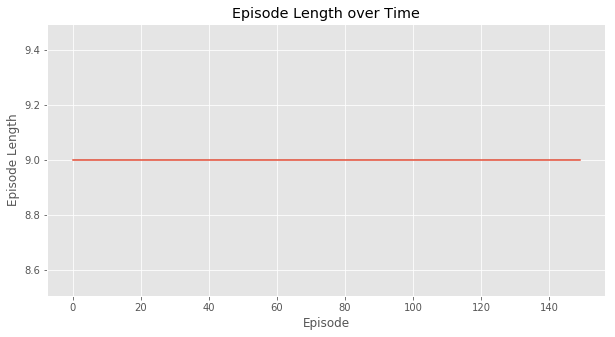

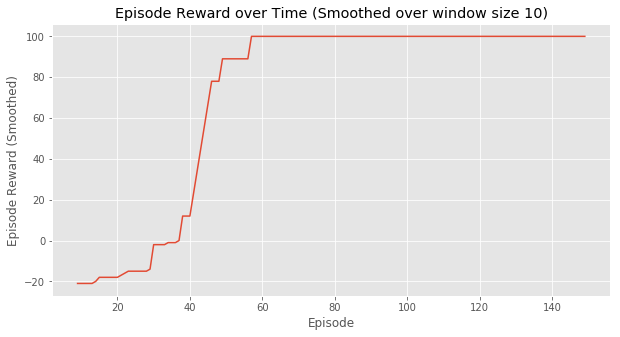

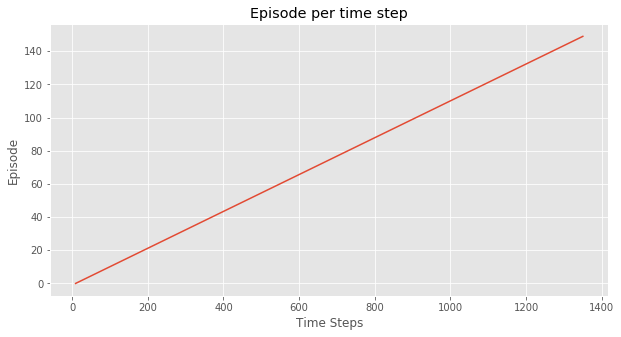

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [1037]:
env = DNNEnv()
Q, stats = q_learning(env, 150)
plotting.plot_episode_stats(stats)